# Stock classification using k-means clustering

First we import the libraries that we are going to need to carry out the analysis:

In [65]:
import numpy as np 
import pandas as pd
import pandas_datareader as dr
import yfinance as yf

from pylab import plot,show
from matplotlib import pyplot as plt
import plotly.express as px

from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
from math import sqrt
from sklearn.cluster import KMeans 
from sklearn import preprocessing

## Load Data
The S&P 500 consists of 500 companies representing all the sectors of the economy. The index covers only large-cap companies listed on the U.S. market, either the New York Stock Exchange or the Nasdaq. Because the S&P 500 represents the largest publicly traded companies in the U.S., it is considered one of the most widely quoted stock market indexes.

By the following script we can scrape the web to collect the tickers for all the individual stocks within the S&P 500:

In [32]:
# Define the url
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Read in the url and scrape ticker data
data_table = pd.read_html(sp500_url)
tickers = data_table[0]['Symbol'].values.tolist()
tickers = [s.replace('\n', '') for s in tickers]
tickers = [s.replace('.', '-') for s in tickers]
tickers = [s.replace(' ', '') for s in tickers]


In [ ]:
# Download prices
prices_list = []
for ticker in tickers:
    try:
        prices = dr.DataReader(ticker,'yahoo','01/01/2020')['Adj Close']
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        prices_list.append(prices)
    except:
        pass
    prices_df = pd.concat(prices_list,axis=1)
prices_df.sort_index(inplace=True)

prices_df.head()

We obtain a dataframe with 737 entries, with the adjusted closing prices from 2020-01-02 to 2022-12-02 of the 500 companies analyzed.

In [4]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737 entries, 2020-01-02 to 2022-12-02
Columns: 500 entries, MMM to ZTS
dtypes: float64(500)
memory usage: 2.8 MB


Calculate average annual percentage return and volatilities over a theoretical one year period

In [85]:
# Create an empity dataframe
returns = pd.DataFrame()

# Define the column Returns
returns['Returns'] = prices_df.pct_change().mean() * 252

# Define the column Volatility
returns['Volatility'] = prices_df.pct_change().std() * sqrt(252)

returns.head()

,Returns,Volatility
MMM,-0.039995,0.289597
AOS,0.153573,0.329671
ABT,0.136395,0.302041
ABBV,0.290401,0.268504
ABMD,0.395636,0.510413


## Determine the optimal number of clusters
The Elbow curve method is a technique used to determine the optimal number of clusters for a K-means clustering. The method works by plotting the sum of squared errors (SSE) for different values of k (number of clusters). The optimal number of clusters is the value of k at which the SSE starts to decrease at a slower rate. The optimal number of clusters is determined by finding the elbow or the point at which the SSE reaches its minimum value. In this case, the optimal number of clusters is 4.

Text(0.5, 1.0, 'Elbow curve')

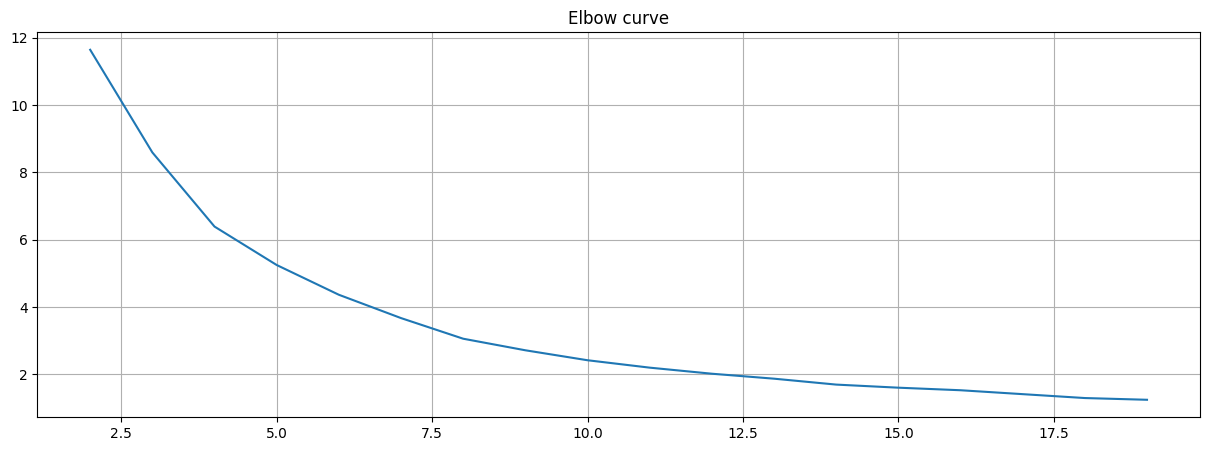

In [86]:
# Format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))

plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

## K-means clustering
K-means clustering is an unsupervised learning algorithm used to group data points into clusters. In the context of creating 4 clusters of stocks using K-means algorithm, the algorithm will iteratively assign data points to clusters based on their similarity of characteristics, or "features", such as returns and volatility. The algorithm initially assigns the data points randomly to the clusters, and then calculates the centroid of each cluster, which is the mean of all the data points within the cluster. The algorithm then compares the data points to the centroid and reassigns them to clusters accordingly. This process is repeated until the centroid of each cluster remains relatively stable, at which point the algorithm stops and each cluster is assigned a label. The end result is a set of 4 clusters, each containing stocks that have similar returns and volatilities.

In [87]:
# Computing K-Means with K = 4 (4 clusters)
centroids,_ = kmeans(data,4)

# Assign each sample to a cluster
idx,_ = vq(data,centroids)

In [89]:
# Create a dataframe with the tickers and the clusters that's belong to
details = [(name,cluster) for name, cluster in zip(returns.index,idx)]
details_df = pd.DataFrame(details)

# Rename columns
details_df.columns = ['Ticker','Cluster']

# Print dataframe
details_df

,Ticker,Cluster
0,MMM,2
1,AOS,3
2,ABT,2
3,ABBV,3
4,ABMD,0
...,...,...
498,YUM,2
499,ZBRA,2
500,ZBH,2
501,ZION,1


In [90]:
# Create another dataframe with the tickers and data from each stock
clusters_df = returns.reset_index()

# Bring the clusters information from the dataframe 'details_df'
clusters_df['Cluster'] = details_df['Cluster']

# Rename columns
clusters_df.columns = ['Ticker', 'Returns', 'Volatility', 'Cluster']

# Print dataframe
clusters_df

,Ticker,Returns,Volatility,Cluster
0,MMM,-0.039995,0.289597,2
1,AOS,0.153573,0.329671,3
2,ABT,0.136395,0.302041,2
3,ABBV,0.290401,0.268504,3
4,ABMD,0.395636,0.510413,0
...,...,...,...,...
498,YUM,0.143062,0.311993,2
499,ZBRA,0.111862,0.427071,2
500,ZBH,0.017178,0.370376,2
501,ZION,0.119896,0.459492,1


In [91]:
# Plot the clusters created using Plotly
fig = px.scatter(clusters_df, x="Returns", y="Volatility", color="Cluster", hover_data=["Ticker"])
fig.update(layout_coloraxis_showscale=False)
fig.show()

In this case, four outliers have been detected in a scatter plot when using the K-Mean algorithm. Outliers are data points that are significantly different from the rest of the data points in the dataset. They can often lead to inaccurate results when using an algorithm, as they don’t fit into the same pattern as the other data points. Therefore, it is important to segregate and remove the outliers to improve the accuracy of the model.

Removing outliers can help the algorithm focus on the most representative data points and reduce the effect of outliers on the results. This can help to increase the accuracy of the model and ensure that the data points are correctly clustered.

In [92]:
# Identify and remove the outliers stocks
returns.drop('MRNA',inplace=True)
returns.drop('ENPH',inplace=True)
returns.drop('TSLA',inplace=True)
returns.drop('CEG',inplace=True)

# Recreate data to feed into the algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

Once the outliers have been eliminated, we repeat the steps performed for clustering using the K-means algorithm to obtain more accurate clusters.

In [93]:
# Computing K-Means with K = 4 (4 clusters)
centroids,_ = kmeans(data,4)

# Assign each sample to a cluster
idx,_ = vq(data,centroids)

In [94]:
# Create a dataframe with the tickers and the clusters that's belong to
details = [(name,cluster) for name, cluster in zip(returns.index,idx)]
details_df = pd.DataFrame(details)

# Rename columns
details_df.columns = ['Ticker','Cluster']

# Create another dataframe with the tickers and data from each stock
clusters_df = returns.reset_index()

# Bring the clusters information from the dataframe 'details_df'
clusters_df['Cluster'] = details_df['Cluster']

# Rename columns
clusters_df.columns = ['Ticker', 'Returns', 'Volatility', 'Cluster']

In [95]:
# Plot the clusters created using Plotly
fig = px.scatter(clusters_df, x="Returns", y="Volatility", color="Cluster", hover_data=["Ticker"])
fig.update(layout_coloraxis_showscale=False)
fig.show()

The graph shows 4 clusters that were generated using a K-means algorithm with 2 variables: average annualized return and average annualized volatility. These variables are used to measure the risk and return of a stock. The 4 clusters represent 4 groups of actions with different levels of risk and return in the period under study.

Clustering is useful for identifying peer groups among stocks, thus allowing differentiation between stocks with different levels of risk and return. This is useful for investors looking to diversify their investment portfolios, as it allows them to identify groups of stocks with different levels of risk and return.

Investors could use the 4 clusters to select a mix of stocks with different levels of risk and return based on their investment objectives. This will help them diversify their portfolio and reduce the risk of their investment, since they will be investing in a variety of assets with different levels of risk.

# Clustering by P/E and dividend rate

It is possible to apply a clustering similar to the one performed previously, exchanging the variables Annualized Average Return and Annualized Average Volatility for PER (Price-Earnings Ratio) and Dividend Rate. In this way we could differentiate between “value” companies and “growth” companies.

In [35]:
# Download trailingPE, dividendRate and marketCap
trailingPE_list = []
dividendRate_list = []
marketCap_list = []

for t in tickers:
   
    tick = yf.Ticker(t)
    ticker_info = tick.info

    try:
        trailingPE = ticker_info['trailingPE']
        trailingPE_list.append(trailingPE)
    except:
        trailingPE_list.append('na')

    try:
        dividendRate = ticker_info['dividendRate']
        dividendRate_list.append(dividendRate)
    except:
        dividendRate_list.append('na')

    try:
        marketCap = ticker_info['marketCap']
        marketCap_list.append(marketCap)
    except:
        marketCap_list.append('na')
        
sp_features_df = pd.DataFrame()
sp_features_df['Ticker'] = tickers

sp_features_df['trailingPE'] = trailingPE_list
sp_features_df['dividendRate'] = dividendRate_list
sp_features_df['marketCap'] = marketCap_list

sp_features_df

,Ticker,trailingPE,dividendRate,marketCap
0,MMM,10.870855,5.96,6.886072e+10
1,AOS,18.907642,1.20,9.155210e+09
2,ABT,23.444696,1.88,1.856913e+11
3,ABBV,21.829334,5.92,2.895356e+11
4,ABMD,64.828476,NaN,1.704222e+10
...,...,...,...,...
498,YUM,34.93447,2.28,3.828903e+10
499,ZBRA,27.188234,NaN,1.358536e+10
500,ZBH,na,0.96,2.535934e+10
501,ZION,9.583248,1.64,7.375666e+09


In [43]:
# Shares with 'na' as dividend rate has no dividend so we have to assign 0 as dividend rate in this cases
sp_features_df["dividendRate"] = sp_features_df["dividendRate"].fillna(0)

# filter shares with 'na' as trailingPE 
df_mask = sp_features_df['trailingPE'] != 'na' 
sp_features_df = sp_features_df[df_mask]

# Convert trailingPE numbers to float type
sp_features_df['trailingPE'] = sp_features_df['trailingPE'].astype(float)

# Removes the rows that contains NULL values 
sp_features_df=sp_features_df.dropna()

# Print dataframe info
sp_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 0 to 502
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        425 non-null    object 
 1   trailingPE    425 non-null    float64
 2   dividendRate  425 non-null    float64
 3   marketCap     425 non-null    float64
dtypes: float64(3), object(1)
memory usage: 16.6+ KB


Text(0.5, 1.0, 'Elbow curve')

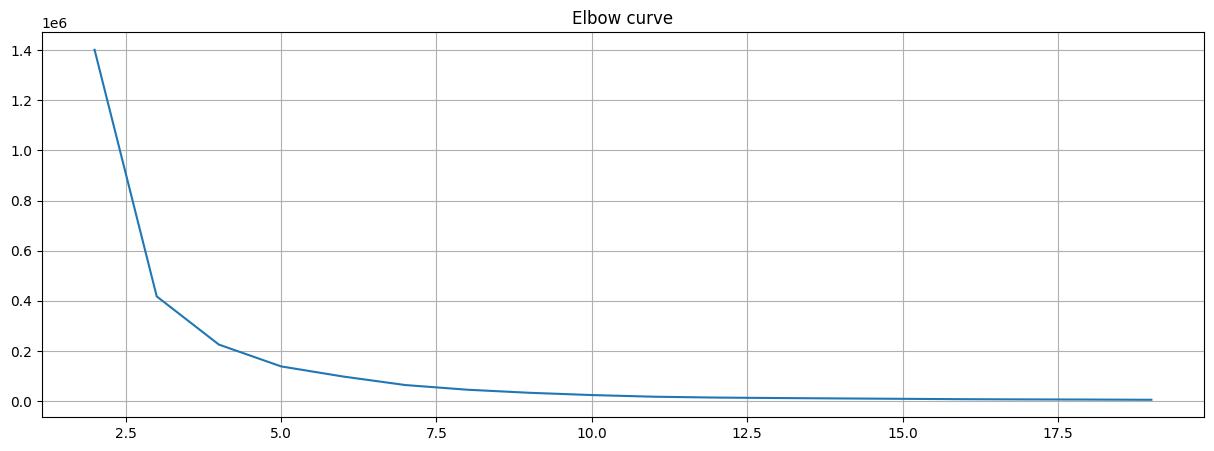

In [58]:
# Format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(sp_features_df['trailingPE']),np.asarray(sp_features_df['dividendRate'])]).T
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))

plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

The optimal number of clusters is 3.

In [63]:
# Computing K-Means with K = 3 (3 clusters)
centroids,_ = kmeans(data,3)

# Assign each sample to a cluster
idx,_ = vq(data,centroids)

# Create the clusters from the numpy array 'data'
cluster_1 = data[idx==0,0],data[idx==0,1]
cluster_2 = data[idx==1,0],data[idx==1,1]
cluster_3 = data[idx==2,0],data[idx==2,1]

# Create a dataframe with the tickers and the clusters that's belong to
details = [(name,cluster) for name, cluster in zip(sp_features_df.index,idx)]
details_df = pd.DataFrame(details)

# Rename columns
details_df.columns = ['Ticker','Cluster']
details_df

,Ticker,Cluster
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
420,497,1
421,498,0
422,499,0
423,501,0


In [64]:
# Create another dataframe with the tickers and data from each stock
clusters_df = sp_features_df

# Bring the clusters information from the dataframe 'details_df'
clusters_df['Cluster'] = details_df['Cluster']

# Rename columns
clusters_df.columns = ['Ticker', 'trailingPE', 'dividendRate', 'marketCap', 'Cluster']

# Plot the clusters created using Plotly
fig = px.scatter(clusters_df, x="dividendRate", y="trailingPE", color="Cluster", hover_data=["Ticker"])
fig.update(layout_coloraxis_showscale=False)
fig.show()

We see results that are too scattered and an unclear clustering. Therefore, it will be necessary to eliminate outliers and normalize the data to achieve more accurate clusters.

In [86]:
df_mask = (sp_features_df['trailingPE'] < 200) & (sp_features_df['dividendRate'] < 5)
sp_features_df = sp_features_df[df_mask]

`MaxAbsScaler` scale each feature by its maximum absolute value.

This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1.0. It does not shift/center the data, and thus does not destroy any sparsity.

In [117]:
max_abs_scaler = preprocessing.MaxAbsScaler()

trailingPE_array = np.array(sp_features_df['trailingPE'].values).reshape(-1,1)
dividendRate_array = np.array(sp_features_df['dividendRate'].values).reshape(-1,1)
marketCap_array = np.array(sp_features_df['marketCap'].values).reshape(-1,1)

sp_features_df['trailingPE_norm'] = max_abs_scaler.fit_transform(trailingPE_array)
sp_features_df['dividendRate_norm'] = max_abs_scaler.fit_transform(dividendRate_array)
sp_features_df['marketCap_norm'] = max_abs_scaler.fit_transform(marketCap_array)

sp_features_df

C:\Users\Facundo Allia\AppData\Local\Temp\ipykernel_20136\1732567014.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Facundo Allia\AppData\Local\Temp\ipykernel_20136\1732567014.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Facundo Allia\AppData\Local\Temp\ipykernel_20136\1732567014.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

,Ticker,trailingPE,dividendRate,marketCap,Cluster,trailingPE_norm,dividendRate_norm,marketCap_norm
1,AOS,18.907642,1.20,9.155210e+09,1.0,0.104937,0.241935,0.003995
2,ABT,23.444696,1.88,1.856913e+11,0.0,0.130118,0.379032,0.081027
4,ABMD,64.828476,0.00,1.704222e+10,1.0,0.359798,0.000000,0.007436
5,ACN,26.648926,4.48,1.799761e+11,2.0,0.147901,0.903226,0.078533
6,ATVI,35.732390,0.47,5.956559e+10,1.0,0.198315,0.094758,0.025992
...,...,...,...,...,...,...,...,...
497,XYL,79.150000,1.20,1.998181e+10,NaN,0.439282,0.241935,0.008719
498,YUM,34.934470,2.28,3.828903e+10,NaN,0.193886,0.459677,0.016708
499,ZBRA,27.188234,0.00,1.358536e+10,NaN,0.150895,0.000000,0.005928
501,ZION,9.583248,1.64,7.375666e+09,NaN,0.053187,0.330645,0.003218


Text(0.5, 1.0, 'Elbow curve')

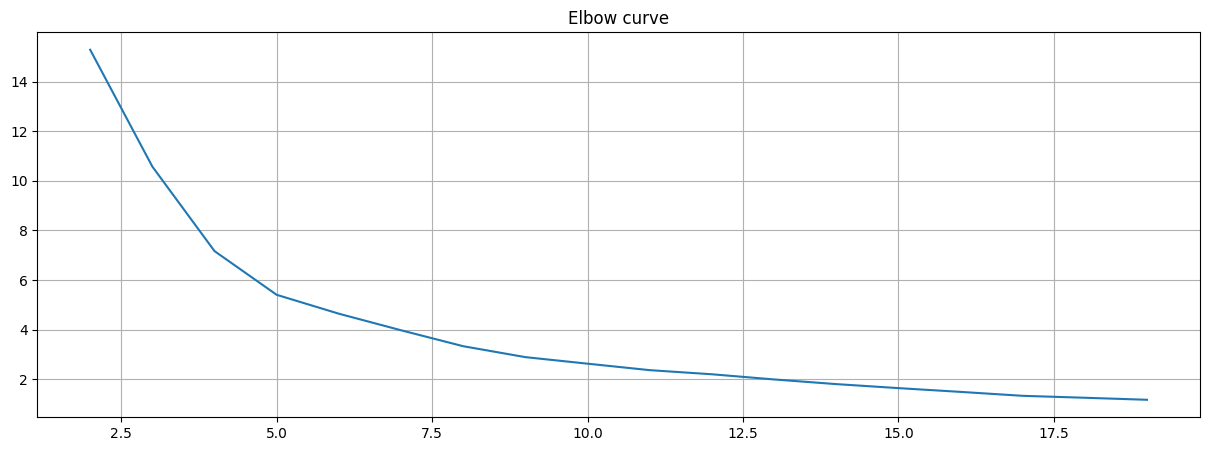

In [118]:
# Format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(sp_features_df['trailingPE_norm']),np.asarray(sp_features_df['dividendRate_norm'])]).T
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))

plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Now, the optimal number of cluster is 4

In [119]:
# Computing K-Means with K = 4 (4 clusters)
centroids,_ = kmeans(data,4)

# Assign each sample to a cluster
idx,_ = vq(data,centroids)

# Create a dataframe with the tickers and the clusters that's belong to
details = [(name,cluster) for name, cluster in zip(sp_features_df.index,idx)]
details_df = pd.DataFrame(details)

clusters_df = pd.DataFrame()
clusters_df['Ticker'] = sp_features_df['Ticker']
clusters_df['trailingPE_norm'] = sp_features_df['trailingPE_norm']
clusters_df['dividendRate_norm'] = sp_features_df['dividendRate_norm']
clusters_df['marketCap_norm'] = sp_features_df['marketCap_norm']
clusters_df['Cluster'] = details_df[1].values
clusters_df

,Ticker,trailingPE_norm,dividendRate_norm,marketCap_norm,Cluster
1,AOS,0.104937,0.241935,0.003995,1
2,ABT,0.130118,0.379032,0.081027,1
4,ABMD,0.359798,0.000000,0.007436,0
5,ACN,0.147901,0.903226,0.078533,2
6,ATVI,0.198315,0.094758,0.025992,0
...,...,...,...,...,...
497,XYL,0.439282,0.241935,0.008719,0
498,YUM,0.193886,0.459677,0.016708,3
499,ZBRA,0.150895,0.000000,0.005928,0
501,ZION,0.053187,0.330645,0.003218,1


In [120]:
# Plot the clusters created using Plotly
fig = px.scatter(clusters_df, x="dividendRate_norm", y="trailingPE_norm", color="Cluster", hover_data=["Ticker"])
fig.update(layout_coloraxis_showscale=False)
fig.show()

# 3 dimensional clustering with K-means++

We can extend the analysis of S&P500 stocks applying k-means++ clustering. This algorithm ensures a smarter initialization of the centroids and improves the quality of the clustering. Apart from initialization, the rest of the algorithm is the same as the standard K-means algorithm. That is K-means++ is the standard K-means algorithm coupled with a smarter initialization of the centroids.

It´s possible to take in count 3 variables for the clusterization:

+ Average annualized return 
+ Average annualized volatility
+ Price to Book



In [30]:
# Download priceToBook and marketCap
priceToBook_list = []
marketCap_list = []
tickers_clean = tickers

for t in tickers:

    try:

        tick = yf.Ticker(t)
        ticker_info = tick.info

        priceToBook = ticker_info['priceToBook']
        marketCap = ticker_info['marketCap']

        priceToBook_list.append(priceToBook)
        marketCap_list.append(marketCap)

    except:

        tickers_clean = tickers.remove(ticker)
        print('The stock ticker {} is not on database'.format(ticker))
        
priceToBook_df = pd.DataFrame()
priceToBook_df['Ticker'] = tickers_clean

priceToBook_df['priceToBook'] = priceToBook_list
priceToBook_df['marketCap'] = marketCap_list

priceToBook_df

,Ticker,priceToBook,ebitda,marketCap
0,MMM,4.985279,6.969000e+09,7.019283e+10
1,AOS,5.277972,7.158000e+08,9.224615e+09
2,ABT,5.282732,1.368800e+10,1.884625e+11
3,ABBV,18.095976,2.940100e+10,2.894295e+11
4,ABMD,11.065802,2.741840e+08,1.700840e+10
...,...,...,...,...
498,YUM,NaN,2.232000e+09,3.801349e+10
499,ZBRA,6.853851,1.148000e+09,1.468893e+10
500,ZBH,2.093498,2.431200e+09,2.568942e+10
501,ZION,1.161731,NaN,8.175192e+09


In [109]:
# Merge dataframes
clusters3d_df = pd.merge(clusters_df, priceToBook_df)

# Removes the rows that contains NULL values 
clusters3d_df.dropna(inplace=True)

# Drop the column with the old clusterization
clusters3d_df.drop(['Cluster'], axis=1, inplace=True)

# Order columns
clusters3d_df = clusters3d_df[['Ticker', 'marketCap', 'Returns', 'Volatility', 'priceToBook']]

# Print Dataframe
clusters3d_df

,Ticker,marketCap,Returns,Volatility,priceToBook
0,MMM,7.019283e+10,-0.039995,0.289597,4.985279
1,AOS,9.224615e+09,0.153573,0.329671,5.277972
2,ABT,1.884625e+11,0.136395,0.302041,5.282732
3,ABBV,2.894295e+11,0.290401,0.268504,18.095976
4,ABMD,1.700840e+10,0.395636,0.510413,11.065802
...,...,...,...,...,...
493,XYL,2.047230e+10,0.194196,0.359985,6.898584
495,ZBRA,1.468893e+10,0.111862,0.427071,6.853851
496,ZBH,2.568942e+10,0.017178,0.370376,2.093498
497,ZION,8.175192e+09,0.119896,0.459492,1.161731


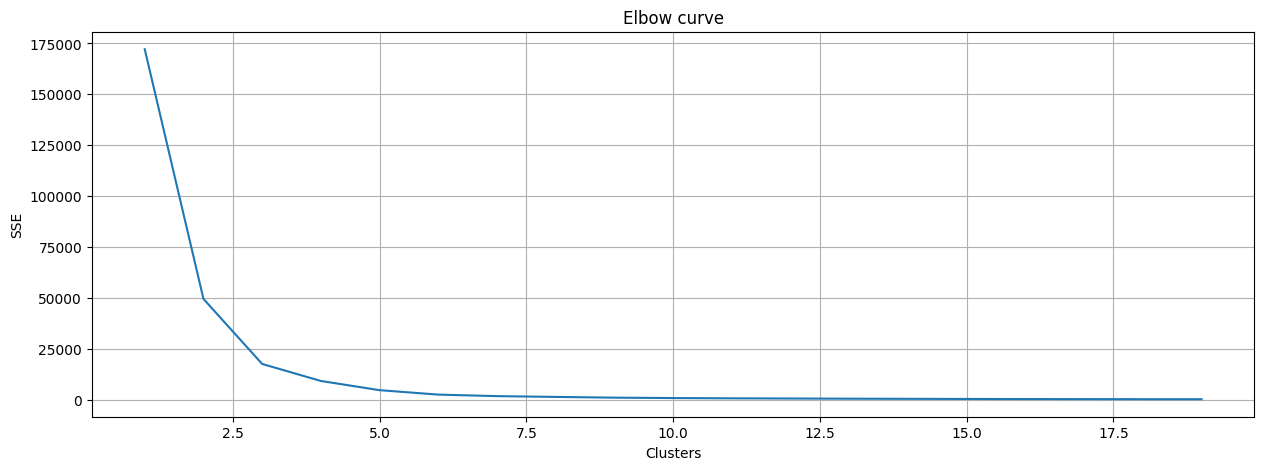

In [118]:
# Format the data as a numpy array to feed into the K-Means algorithm
data3d = np.asarray([np.asarray(clusters3d_df['Returns']), np.asarray(clusters3d_df['Volatility']), np.asarray(clusters3d_df['priceToBook'])]).T
X = data3d

#elbow method
distorsions = []
for i in range(1,20):
    k_means = KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
    
#plot elbow curve
fig = plt.figure(figsize=(15, 5))

plt.plot(np.arange(1,20),distorsions)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.title('Elbow curve')
plt.grid(True)
plt.show()

The optimal number of clusters is 3

In [119]:
# Create clusters
k_means_optimum = KMeans(n_clusters = 3, init = 'k-means++',  random_state=42)
y = k_means_optimum.fit_predict(X)
print(y)

[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [123]:
# Plot 3D graph with plotly
clusters3d_df['cluster'] = y 

fig = px.scatter_3d(clusters3d_df, x='Returns', y='Volatility', z='priceToBook',
              color='cluster', hover_data=["Ticker"])
fig.show()

Again, we note the presence of outliers. We remove them individually and repeat the steps to cluster again

In [131]:
# Identify and remove the outliers stocks
clusters3d_df.drop(clusters3d_df[(clusters3d_df['Ticker'] == 'HD')].index, inplace=True)
clusters3d_df.drop(clusters3d_df[(clusters3d_df['Ticker'] == 'CL')].index, inplace=True)

# Recreate data to feed into the algorithm
data3d = np.asarray([np.asarray(clusters3d_df['Returns']), np.asarray(clusters3d_df['Volatility']), np.asarray(clusters3d_df['priceToBook'])]).T
X = data3d

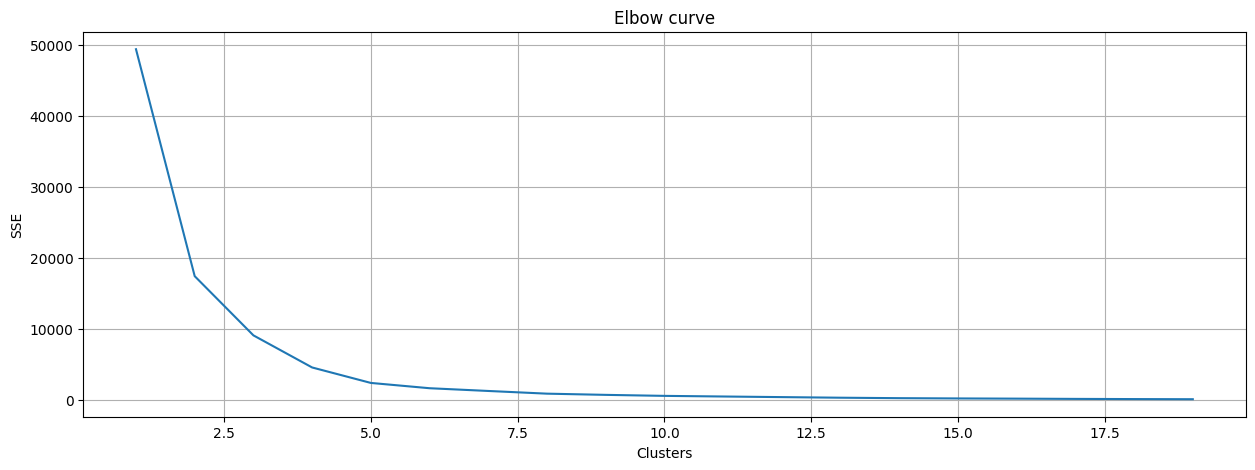

In [140]:
#elbow method
distorsions = []
for i in range(1,20):
    k_means = KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
    
#plot elbow curve
fig = plt.figure(figsize=(15, 5))

plt.plot(np.arange(1,20),distorsions)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.title('Elbow curve')
plt.grid(True)
plt.show()

The optimal number of clusters is 3

In [141]:
k_means_optimum = KMeans(n_clusters = 3, init = 'k-means++',  random_state=42)
y = k_means_optimum.fit_predict(X)
clusters3d_df['cluster'] = y 

fig = px.scatter_3d(clusters3d_df, x='priceToBook', y='Returns', z='Volatility',
              color='cluster', hover_data=["Ticker"])
fig.show()

Now we achieve a more accurate clusterization